In [ ]:
!pip install pyspark
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.mllib.recommendation import Rating
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.appName("Tags prediction")\
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .getOrCreate()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=cb627d0eb053983dc24d97d27e96a45322fc14b15d25c7ca8d7362a3f0835116
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tags = spark.read.csv("/content/drive/MyDrive/Tags.csv", header=True,sep=",",inferSchema=True)

In [ ]:
tags.show()

# tags.cache()

+---+--------------------+
| Id|                 Tag|
+---+--------------------+
| 80|                flex|
| 80|      actionscript-3|
| 80|                 air|
| 90|                 svn|
| 90|         tortoisesvn|
| 90|              branch|
| 90|branching-and-mer...|
|120|                 sql|
|120|             asp.net|
|120|             sitemap|
|180|           algorithm|
|180|   language-agnostic|
|180|              colors|
|180|         color-space|
|260|                  c#|
|260|                .net|
|260|           scripting|
|260|compiler-construc...|
|330|                 c++|
|330|                 oop|
+---+--------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import split, collect_list
grouped_df = tags.groupBy("Id").agg(collect_list("Tag").alias("combined_tags"))

# grouped_df.cache()
# Show the grouped and combined DataFrame
grouped_df.show(truncate=False)

+----+-------------------------------------------------------------+
|Id  |combined_tags                                                |
+----+-------------------------------------------------------------+
|120 |[sql, asp.net, sitemap]                                      |
|330 |[c++, oop, class, nested-class]                              |
|470 |[.net, web-services]                                         |
|580 |[sql-server, sql-server-2005, deployment, release-management]|
|650 |[c#, visual-studio, versioning]                              |
|1010|[c#, asp.net]                                                |
|1160|[svn, msbuild, cruisecontrol.net]                            |
|1180|[web-applications, dns, subdomain, account]                  |
|1300|[.net, .net-3.5, msbuild, nant]                              |
|1600|[sql-server, sql-server-2008]                                |
|2630|[powershell, cmdlets]                                        |
|2750|[optimization, setter, gette

In [ ]:
file_path = "/content/drive/MyDrive/Questions.csv"

In [ ]:
df = spark.read.options(header=True, inferSchema=True, quotes='"', escape="\"", multiLine=True).csv(file_path)

In [ ]:
df= df.drop(df.ClosedDate,df.CreationDate,df.OwnerUserId)

In [ ]:
Question_tag = df.join(grouped_df, on="Id", how="inner")

In [ ]:
# filtering the dataset fror score > 5 to make the dataset better
from pyspark.sql.functions import explode, col
Question_tag = Question_tag.filter((col("Score") > 5))


In [ ]:
duplicate_count = Question_tag.groupBy(Question_tag.Id).count().filter("count > 1")


# Show the resulting DataFrame
duplicate_count.show()

+---+-----+
| Id|count|
+---+-----+
+---+-----+



In [ ]:
all_tags_df = Question_tag.select(explode("combined_tags").alias("tag"))

all_tags_df_distint = all_tags_df.distinct()

#all_tags_df.show()
#print(all_tags_df.count())

#print(all_tags_df_distint.count())

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc,lit,udf,regexp_replace
from pyspark.sql.types import StructType, StructField, StringType
import pyspark.sql.functions as F
from pyspark.ml.feature import Tokenizer

all_tags_df_with_count = all_tags_df.withColumn("count", lit(1))
tag_counts = all_tags_df_with_count.groupBy("tag").count()


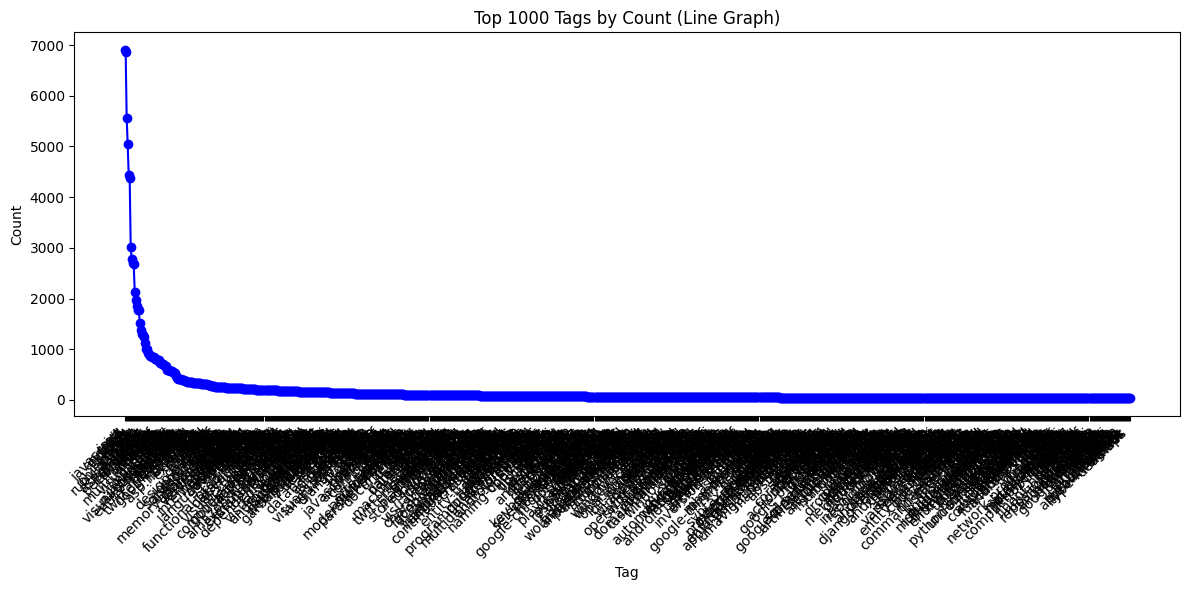

In [ ]:
# # Group by tag and count the occurrences
# tag_counts = all_tags_df_with_count.groupBy("tag").count()

# # Sort by count in descending order and select the top 100
# top_100_tags = tag_counts.orderBy(desc("count")).limit(1000)


# # Convert PySpark DataFrame to Pandas DataFrame for plotting
# pandas_top_100_tags = top_100_tags.toPandas()

# # Plot the line graph for the top 100 tags
# plt.figure(figsize=(12, 6))
# plt.plot(pandas_top_100_tags["tag"], pandas_top_100_tags["count"], marker='o', linestyle='-', color='b')
# plt.xlabel("Tag")
# plt.ylabel("Count")
# plt.title("Top 1000 Tags by Count (Line Graph)")
# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()
# plt.show()

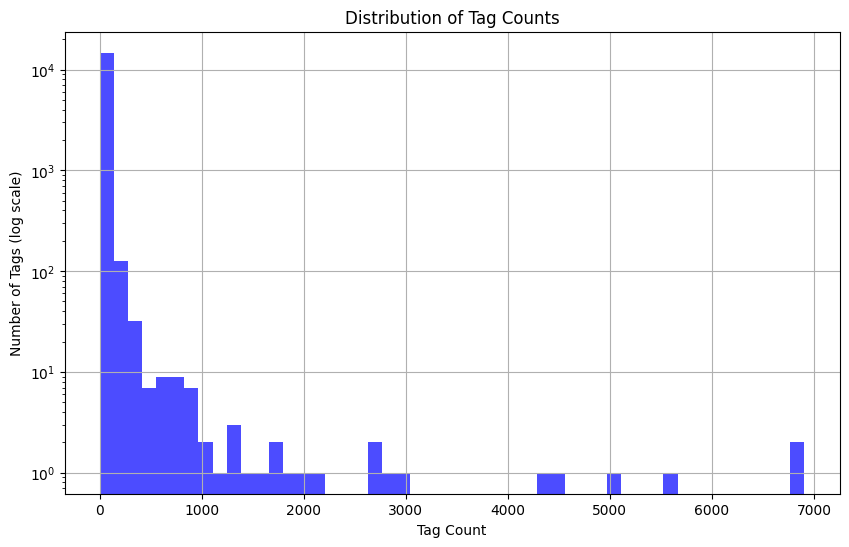

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Convert the Spark DataFrame to a Pandas DataFrame
# tag_counts_pd = tag_counts.toPandas()

# # Plot the histogram with adjustments
# plt.figure(figsize=(10, 6))
# # Use log scale if needed by setting log=True
# plt.hist(tag_counts_pd['count'], bins=50, color='blue', alpha=0.7, log=True)
# plt.title('Distribution of Tag Counts')
# plt.xlabel('Tag Count')
# plt.ylabel('Number of Tags (log scale)')
# plt.grid(True)
# plt.show()


In [ ]:
# from pyspark.ml.feature import CountVectorizer, IDF
# from pyspark.ml.clustering import KMeans
# from pyspark.ml import Pipeline

# cv = CountVectorizer(inputCol="tag", outputCol="tf_features")
# idf = IDF(inputCol="tf_features", outputCol="features")
# kmeans = KMeans(predictionCol="cluster").setK(3).setSeed(1)  # Set K to the desired number of clusters

# pipeline = Pipeline(stages=[cv, idf, kmeans])

# # Fit the pipeline to training documents.
# model = pipeline.fit(tag_counts)

# # Transform the DataFrame to include cluster predictions
# result = model.transform(tag_counts)

# # Show the resulting clusters
# result.select("tags", "cluster").show()

# from pyspark.ml.evaluation import ClusteringEvaluator

# # Assume that 'features' are the TF-IDF  vectorized tags
# silhouette_scores = []
# for k in range(2, 10):  # Example range, adjust based on your specific case
#     kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
#     model = kmeans.fit(result)
#     predictions = model.transform(result)
#     evaluator = ClusteringEvaluator()
#     silhouette = evaluator.evaluate(predictions)
#     silhouette_scores.append((k, silhouette))

# # Find the best K based on the highest silhouette score
# best_k = max(silhouette_scores, key=lambda item: item[1])[0]

In [ ]:

threshold = 800  # This is an example value, adjust according to your needs

# Filter the tags to only those with a count above the threshold
filtered_tags = tag_counts.filter(col("count") >= threshold)

# Sort the tags by count in descending order
sorted_tags = filtered_tags.orderBy(col("count").desc())

# Now, you can collect this DataFrame into a local list of rows if it's small enough
# Be cautious with collect() on large datasets
best_tags_list = sorted_tags.collect()


In [ ]:
from pyspark.sql.functions import col, array, array_intersect
#exploded_df = Question_tag.select("Id","Title", "Body", explode("combined_tags").alias("tag"))

exploded_df = Question_tag.select("Id","Title", "Body", explode("combined_tags").alias("tag"))
# Filter based on whether each tag is in the list of top tags
filtered_df = exploded_df.join(sorted_tags, "tag", "inner").groupBy("Id", "Title", "Body") \
    .agg(collect_list("tag").alias("filtered_tags"))

# Show the resulting DataFrame
filtered_df.show(truncate=False)

+----+------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords

nltk.download("stopwords")

# list of stopwords in english
stopwords_list = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_html_tags(text):
    clean_text = F.regexp_replace(text, "<.*?>", "")
    return clean_text

# method to remove stopwords
# def remove_stopwords_udf(tokens):
#     filtered_tokens = [token for token in tokens if token.lower() not in stopwords_list]
#     return filtered_tokens
# remove_stopwords_udf = udf(remove_stopwords_udf, StringType())


In [ ]:
filtered_df = filtered_df.withColumn("HtmlR_body", remove_html_tags(col("Body")))

In [ ]:
filtered_df.show()

+----+--------------------+--------------------+-----------------+--------------------+
|  Id|               Title|                Body|    filtered_tags|          HtmlR_body|
+----+--------------------+--------------------+-----------------+--------------------+
| 120|   ASP.NET Site Maps|<p>Has anyone got...|   [asp.net, sql]|Has anyone got ex...|
| 330|Should I use nest...|<p>I am working o...|            [c++]|I am working on a...|
| 580|Deploying SQL Ser...|<p>I wonder how y...|     [sql-server]|I wonder how you ...|
|1300|Is nAnt still sup...|<p>I am using MSB...|           [.net]|I am using MSBuil...|
|1610|Can I logically r...|<p>If I'm adding ...|     [sql-server]|If I'm adding a c...|
|1970|What language do ...|<p>PostgreSQL is ...|            [sql]|PostgreSQL is int...|
|2530|How do you disabl...|<p>How do you dis...|           [html]|How do you disabl...|
|2540|Good STL-like lib...|<p>What are good ...|              [c]|What are good lib...|
|2900|MySQL/Apache Erro...|<p>I 

In [ ]:
df.unpersist()
tags.unpersist()
grouped_df.unpersist()

DataFrame[Id: int, combined_tags: array<string>]

In [ ]:
filtered_df = filtered_df.withColumn("body_without_punctuation", regexp_replace(filtered_df["HtmlR_body"], r'[^\w\s]', ''))

filtered_df = filtered_df.withColumn("Title_without_punctuation", regexp_replace(filtered_df["Title"], r'[^\w\s]', ''))

In [ ]:
tokenizer = Tokenizer(inputCol="body_without_punctuation", outputCol="body_tokens")
tokenizer1 = Tokenizer(inputCol="Title_without_punctuation", outputCol="title_tokens")
filtered_df = tokenizer.transform(filtered_df)

filtered_df = tokenizer1.transform(filtered_df)

from pyspark.ml.feature import StopWordsRemover
stopwords_remover = StopWordsRemover(inputCol="body_tokens", outputCol="filtered_body_tokens")
filtered_df = stopwords_remover.transform(filtered_df)

stopwords_remover = StopWordsRemover(inputCol="title_tokens", outputCol="filtered_title_tokens")
filtered_df = stopwords_remover.transform(filtered_df)


In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import CountVectorizer, Tokenizer, IDF
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import concat_ws

from pyspark.sql.functions import explode

from pyspark.ml.feature import StringIndexer

exploded_df = filtered_df.select("Id", "Title", explode("filtered_tags").alias("tag"))
exploded_df.show()
distinct_tags = exploded_df.select("tag").distinct()

string_indexer = StringIndexer(inputCol="tag", outputCol="indexed_label")
indexer_model = string_indexer.fit(distinct_tags)
indexed_tags = indexer_model.transform(distinct_tags)

indexed_tags.show()
exploded_df = exploded_df.join(indexed_tags, on="tag", how="left")
exploded_df.show()
filtered_df = exploded_df.join(filtered_df, on="Id", how="left")

#filtered_df = filtered_df.dropDuplicates(['Id'])
#filtered_df.show()

+----+--------------------+----------+
|  Id|               Title|       tag|
+----+--------------------+----------+
| 120|   ASP.NET Site Maps|   asp.net|
| 120|   ASP.NET Site Maps|       sql|
| 330|Should I use nest...|       c++|
| 580|Deploying SQL Ser...|sql-server|
|1300|Is nAnt still sup...|      .net|
|1610|Can I logically r...|sql-server|
|1970|What language do ...|       sql|
|2530|How do you disabl...|      html|
|2540|Good STL-like lib...|         c|
|2900|MySQL/Apache Erro...|     mysql|
|2900|MySQL/Apache Erro...|       php|
|3150|How to set up uni...|       c++|
|3230|How do you pack a...|       c++|
|3260|Peak detection of...| algorithm|
|3470|How do I Transfor...|sql-server|
|3530|How do I run Rake...|      ruby|
|4110|What program can ...|       sql|
|4110|What program can ...|sql-server|
|4230|The Difference Be...|   asp.net|
|4630|How can I Java we...|      java|
+----+--------------------+----------+
only showing top 20 rows

+-----------+-------------+
|        t

In [ ]:

from pyspark.ml.feature import CountVectorizer, IDF

vectorizer_title = CountVectorizer(inputCol="filtered_title_tokens", outputCol="title_rawFeatures", minDF=3, vocabSize=5000)
model_title = vectorizer_title.fit(filtered_df)
featurizedData_title = model_title.transform(filtered_df)

idf_title = IDF(inputCol="title_rawFeatures", outputCol="title_features")
idfModel_title = idf_title.fit(featurizedData_title)
rescaledData = idfModel_title.transform(featurizedData_title)
rescaledData.show(5)


+----+----------+--------------------+-------------+--------------------+--------------------+--------------+--------------------+------------------------+-------------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+
|  Id|       tag|               Title|indexed_label|               Title|                Body| filtered_tags|          HtmlR_body|body_without_punctuation|Title_without_punctuation|         body_tokens|        title_tokens|filtered_body_tokens|filtered_title_tokens|   title_rawFeatures|      title_features|
+----+----------+--------------------+-------------+--------------------+--------------------+--------------+--------------------+------------------------+-------------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+
| 120|   asp.net|   ASP.NET Site Maps|          4.0|   ASP.NET Site Maps|

In [ ]:
from pyspark.ml.feature import CountVectorizer, IDF

vectorizer_body = CountVectorizer(inputCol="filtered_body_tokens", outputCol="body_rawFeatures", minDF=3, vocabSize=5000)
model_body = vectorizer_body.fit(filtered_df)
featurizedData_body = model_body.transform(filtered_df)

idf_body = IDF(inputCol="body_rawFeatures", outputCol="body_features")
idfModel_body = idf_body.fit(featurizedData_body)
rescaledData_body = idfModel_body.transform(featurizedData_body)
rescaledData_body.show(5)


+----+----------+--------------------+-------------+--------------------+--------------------+--------------+--------------------+------------------------+-------------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+
|  Id|       tag|               Title|indexed_label|               Title|                Body| filtered_tags|          HtmlR_body|body_without_punctuation|Title_without_punctuation|         body_tokens|        title_tokens|filtered_body_tokens|filtered_title_tokens|    body_rawFeatures|       body_features|
+----+----------+--------------------+-------------+--------------------+--------------------+--------------+--------------------+------------------------+-------------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+
| 120|   asp.net|   ASP.NET Site Maps|          4.0|   ASP.NET Site Maps|

In [ ]:
#rescaledData = rescaledData.join(rescaledData_body.select("Id"), on='Id', how='inner')
from pyspark.ml.feature import VectorAssembler

rescaledData = rescaledData.select("Id", "title_features","indexed_label").join(rescaledData_body.select("Id", "body_features"), on='Id', how='inner')
rescaledData.show()

assembler = VectorAssembler(
    inputCols=["title_features", "body_features"],
    outputCol="features"
)

# Transform the DataFrame
rescaledData = assembler.transform(rescaledData)

+----+--------------------+-------------+--------------------+
|  Id|      title_features|indexed_label|       body_features|
+----+--------------------+-------------+--------------------+
| 120|(5000,[34,448,607...|          4.0|(5000,[0,15,16,24...|
| 330|(5000,[6,166,237,...|          8.0|(5000,[0,1,2,3,5,...|
| 470|(5000,[75,798,266...|          0.0|(5000,[0,1,3,4,31...|
| 580|(5000,[24,32,97,8...|         29.0|(5000,[0,1,15,19,...|
| 650|(5000,[70,142,178...|          7.0|(5000,[0,1,2,3,11...|
|1010|(5000,[7,25,1118,...|          7.0|(5000,[0,3,6,11,1...|
|1300|(5000,[52,577,784...|          0.0|(5000,[0,1,9,14,4...|
|1600|(5000,[16,58,77,2...|         29.0|(5000,[5,16,17,59...|
|2780|(5000,[296,1331,1...|          7.0|(5000,[0,2,34,105...|
|2840|(5000,[24,32,363,...|         28.0|(5000,[0,3,13,14,...|
|3150|(5000,[2,27,86,13...|          8.0|(5000,[0,3,11,27,...|
|3260|(5000,[1114,1294]...|          1.0|(5000,[0,1,4,9,16...|
|4110|(5000,[6,24,215,2...|         28.0|(5000,[0,31,78

In [ ]:
from pyspark.ml.clustering import LDA
lda = LDA(k=10, maxIter=10)
ldaModel = lda.fit(rescaledData)

transformed_data = ldaModel.transform(rescaledData)
transformed_data.show()
#df_with_topic_distribution = transformed_data.select("tweet", "topicDistribution")
#df_with_topic_distribution.show(5)

+----+--------------------+-------------+--------------------+--------------------+--------------------+
|  Id|      title_features|indexed_label|       body_features|            features|   topicDistribution|
+----+--------------------+-------------+--------------------+--------------------+--------------------+
| 120|(5000,[34,448,607...|          4.0|(5000,[0,15,16,24...|(10000,[34,448,60...|[6.9672321491464E...|
| 330|(5000,[6,166,237,...|          8.0|(5000,[0,1,2,3,5,...|(10000,[6,166,237...|[0.51815479689862...|
| 470|(5000,[75,798,266...|          0.0|(5000,[0,1,3,4,31...|(10000,[75,798,26...|[0.30732956289551...|
| 580|(5000,[24,32,97,8...|         29.0|(5000,[0,1,15,19,...|(10000,[24,32,97,...|[1.95018716060176...|
| 650|(5000,[70,142,178...|          7.0|(5000,[0,1,2,3,11...|(10000,[70,142,17...|[4.20598492371170...|
|1010|(5000,[7,25,1118,...|          7.0|(5000,[0,3,6,11,1...|(10000,[7,25,1118...|[6.06600271308361...|
|1300|(5000,[52,577,784...|          0.0|(5000,[0,1,9,1

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler1 = VectorAssembler(
    inputCols=["features", "topicDistribution"],
    outputCol="topic_features"
)

# Transform the DataFrame
transformed_data = assembler1.transform(transformed_data)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [ ]:
#rescaledData.unpersist()
#transformed_data.cache()

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Assuming rescaledData is your DataFrame and it's correctly preprocessed
train_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=42)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(labelCol="indexed_label", featuresCol="topic_features")

# Create a Pipeline
pipeline = Pipeline(stages=[rf])

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [12])  # Number of trees, add more values as needed
             .addGrid(rf.maxDepth, [30])  # Depth of trees, add more values as needed
             .build())

# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="f1")
recallevaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="recallByLabel")

# Set up the CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # Number of folds in cross-validation

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_data)


# Make predictions on test data. cvModel uses the best model found.
predictions = cvModel.transform(test_data)
predictions.show(70)

# Evaluate the model
f1_score = evaluator.evaluate(predictions)
recall = recallevaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")

print(f"recall Score: {recall}")

+------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    Id|      title_features|indexed_label|       body_features|            features|   topicDistribution|      topic_features|       rawPrediction|         probability|prediction|
+------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   470|(5000,[75,798,266...|          0.0|(5000,[0,1,3,4,31...|(10000,[75,798,26...|[0.30732956289551...|(10010,[75,798,26...|[1.02078014578058...|[0.08506501214838...|       7.0|
|  1300|(5000,[52,577,784...|          0.0|(5000,[0,1,9,14,4...|(10000,[52,577,78...|[0.52698831403205...|(10010,[52,577,78...|[0.62752046998357...|[0.05229337249863...|       8.0|
|  2780|(5000,[296,1331,1...|          7.0|(5000,[0,2,34,105...|(10000,[296,1331,...|[6.2788397

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'predictions' is your DataFrame with prediction results
# and it has columns 'prediction' for predicted labels and 'label' for true labels

evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Accuracy:", accuracy)
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.572962962962963
Weighted Precision: 0.6263012872697075
Weighted Recall: 0.5729629629629629
F1 Score: 0.5558252616556266


In [ ]:
# bestModel = cvModel.bestModel

# # Now, if your estimator is a pipeline, you should extract the specific model
# # Assuming the RandomForestClassifier is the last stage in the pipeline
# rfModel = bestModel.stages[-1]

# # Now you can access the feature importances
# feature_importances = rfModel.featureImportances

# print("Feature Importances:", feature_importances)



In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

layers = [len(transformed_data.select('topic_features').first()[0]),128, 64, len(rescaledData.select('indexed_label').distinct().collect())]

mlp = MultilayerPerceptronClassifier(layers=layers, labelCol='indexed_label', featuresCol='topic_features', seed=42)

mlp_model = mlp.fit(train_data)

predictions1 = mlp_model.transform(test_data)

predictions1.show()
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", metricName="f1")
recallevaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="recallByLabel")

accuracy = evaluator.evaluate(predictions1)
print("f1 score:", accuracy)

recall = recallevaluator.evaluate(predictions)

print(f"recall Score: {recall}")

+-----+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   Id|      title_features|indexed_label|       body_features|            features|   topicDistribution|      topic_features|       rawPrediction|         probability|prediction|
+-----+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  470|(5000,[75,798,266...|          0.0|(5000,[0,1,3,4,31...|(10000,[75,798,26...|[0.30732956289551...|(10010,[75,798,26...|[14.8139886761199...|[9.28556359713743...|       4.0|
| 1300|(5000,[52,577,784...|          0.0|(5000,[0,1,9,14,4...|(10000,[52,577,78...|[0.52698831403205...|(10010,[52,577,78...|[22.3307495186264...|[0.99973200548938...|       0.0|
| 2780|(5000,[296,1331,1...|          7.0|(5000,[0,2,34,105...|(10000,[296,1331,...|[6.2788397385501

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'predictions' is your DataFrame with prediction results
# and it has columns 'prediction' for predicted labels and 'label' for true labels

evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions1, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions1, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions1, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions1, {evaluator.metricName: "f1"})

print("Accuracy:", accuracy)
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6475925925925926
Weighted Precision: 0.6467847973694147
Weighted Recall: 0.6475925925925926
F1 Score: 0.6465543265329317


In [ ]:

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
lr = LogisticRegression(
    labelCol="indexed_label", featuresCol="topic_features",regParam=0.1
)

# paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1, 1.0]).build()

# crossval = CrossValidator(estimator=lr,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="sentiment", metricName="areaUnderROC"),
#                           numFolds=10)
lrModel = lr.fit(train_data)
# bestModel = lrModel.bestModel
# print("Best Model Coefficients: " + str(bestModel.coefficients))
# print("Best Model Intercept: " + str(bestModel.intercept))
predictions2 = lrModel.transform(test_data)
predictions2.show(70)
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="f1")
recallevaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction", metricName="recallByLabel")


recall = recallevaluator.evaluate(predictions)

print(f"recall Score: {recall}")

lr_accuracy = evaluator.evaluate(predictions2)
print(f"F1 Score: {lr_accuracy}")






+------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    Id|      title_features|indexed_label|       body_features|            features|   topicDistribution|      topic_features|       rawPrediction|         probability|prediction|
+------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   470|(5000,[75,798,266...|          0.0|(5000,[0,1,3,4,31...|(10000,[75,798,26...|[0.30732956289551...|(10010,[75,798,26...|[0.96301309593008...|[0.04654274339727...|       7.0|
|  1300|(5000,[52,577,784...|          0.0|(5000,[0,1,9,14,4...|(10000,[52,577,78...|[0.52698831403205...|(10010,[52,577,78...|[1.97066841537132...|[0.14966020901151...|       0.0|
|  2780|(5000,[296,1331,1...|          7.0|(5000,[0,2,34,105...|(10000,[296,1331,...|[6.2788397

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'predictions' is your DataFrame with prediction results
# and it has columns 'prediction' for predicted labels and 'label' for true labels

evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions2, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions2, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions2, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions2, {evaluator.metricName: "f1"})

print("Accuracy:", accuracy)
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6768518518518518
Weighted Precision: 0.6785787227571304
Weighted Recall: 0.6768518518518518
F1 Score: 0.6632054882776914


In [ ]:

joined_df = predictions.alias("pred").join(
    predictions1.alias("pred1"),
    on=["Id"],
    how="inner"
).join(
    predictions2.alias("pred2"),
    on=["Id"],
    how="inner"
)

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType
import random
from collections import Counter

def vote(column1, column2, column3):
    votes = Counter([column1, column2, column3])
    winner, _ = votes.most_common(1)[0]
    return winner


vote_udf = udf(vote, StringType())

hybrid_predictions = joined_df.withColumn(
    "supervised_hybrid_prediction",
    vote_udf(
        col("pred.prediction"),
        col("pred1.prediction"),
        col("pred2.prediction")
    )
)
hybrid_predictions.show()

+-----+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------------------------+
|   Id|      title_features|indexed_label|       body_features|            features|   topicDistribution|      topic_features|       rawPrediction|         probability|prediction|      title_features|indexed_label|       body_features|            features|   topicDistribution|      topic_features|       rawPrediction|         probability|prediction|      title_features|indexed_label|       body_features|            features|   topicDistributio

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

hybrid_predictions = hybrid_predictions.withColumn("supervised_hybrid_prediction", col("supervised_hybrid_prediction").cast(DoubleType()))

# Select only the prediction and true labels columns
predictionAndLabels = hybrid_predictions.select(['supervised_hybrid_prediction', 'pred1.indexed_label'])

# Create a MulticlassClassificationEvaluator instance
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="supervised_hybrid_prediction")

# Calculate precision, recall, and F1 score
recall = evaluator.evaluate(predictionAndLabels, {evaluator.metricName: "recallByLabel"})
f1 = evaluator.evaluate(predictionAndLabels, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictionAndLabels, {evaluator.metricName: "weightedPrecision"})

# Print the results
# print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1)

Recall = 0.3793103448275862
F1 Score = 0.840869672126855


In [ ]:
print("precision= %s" % precision)

precision= 0.8732705353876603


In [ ]:
from pyspark.ml.feature import IndexToString

labelConverter = IndexToString(inputCol="supervised_hybrid_prediction", outputCol="tag_pred", labels=indexer_model.labels)
hybrid_predictions = labelConverter.transform(hybrid_predictions)


In [ ]:
hybrid_predictions.show()

+-----+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+----------------------------+----------+
|   Id|      title_features|indexed_label|       body_features|            features|   topicDistribution|      topic_features|       rawPrediction|         probability|prediction|      title_features|indexed_label|       body_features|            features|   topicDistribution|      topic_features|       rawPrediction|         probability|prediction|      title_features|indexed_label|       body_features|            features|   topic